# Achievement 6.6: Sourcing & Analyzing Time Series Data

### Objective: To use existing Project time-series data, or, to import data using QuandL and to wrangle / analyze the data before decomposing the data and conducting stationarity tests and transformations (log / differencing).

#### Our data set already has transactional data, of which there are two options:
- 'Calendar' > The information available in this file only spans one year (as it is an indication of availability & pricing for the up coming season. Because the date range is only 1 year, I don't think it'll provide much additional insight on our prior questions (e.g what months are the most expensive to visit > If we only have one years data we can't assess whether there is trends / seasonality because we don't have the opportunity to review multiple annual cycles).
- 'Review_details' > This file contains review data and has a date for the time the review was posted. It's a fairly large assumption, but we can surmize that a customer would leave a review within a few days (perhaps at most a week or 2) after having completed a stay so the idea here would perhaps be to review 'count of reviews' against time (months) to assess both the tragectory of booking quantities over the years and the popularity of the service for the Amsterdam Region (using some listing_id related data such as property type / group size etc.)

#### Sections:

- Library & data importing
- Data consistency checks, wrangling & cleaning
- Time-series component analysis using decomposition
- Testing for Stationarity
- Stationarizing the data (if  req.)
- Concluding comments

### 1. Importing your libraries and data

In [1]:
#As we are currently using existing data for we won't install QuandL. We may proceed to generating a new script IF these results don't yield any insights

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import os
from datetime import datetime

plt.style.use('fivethirtyeight')

path = r'C:\Users\mojos\Documents\Career Foundry Course\Data Immersion\Section 6\AirBnB Data'

In [2]:
review = pd.read_csv(os.path.join(path,'Raw','reviews_details.csv'))
listing = pd.read_csv(os.path.join(path,'prepared','listings_sub1K.csv'))

### 2. Reviewing the available time-series data and performing wrangling / cleaning / merges

In [3]:
review.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2818,1191,2009-03-30,10952,Lam,Daniel is really cool. The place was nice and ...
1,2818,1771,2009-04-24,12798,Alice,Daniel is the most amazing host! His place is ...
2,2818,1989,2009-05-03,11869,Natalja,We had such a great time in Amsterdam. Daniel ...
3,2818,2797,2009-05-18,14064,Enrique,Very professional operation. Room is very clea...
4,2818,3151,2009-05-25,17977,Sherwin,Daniel is highly recommended. He provided all...


In [4]:
review.dtypes

listing_id        int64
id                int64
date             object
reviewer_id       int64
reviewer_name    object
comments         object
dtype: object

In [5]:
# Removing unncessary columns & correcting dtypes
review_2 = review.drop(columns = ['id','reviewer_id','reviewer_name','comments'])
review_2['listing_id'] = review_2['listing_id'].astype('str')

In [6]:
review_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 431830 entries, 0 to 431829
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  431830 non-null  object
 1   date        431830 non-null  object
dtypes: object(2)
memory usage: 6.6+ MB


In [7]:
review_2.shape

(431830, 2)

In [8]:
#Converting date value to rounded month value
review_2['date_converted'] = pd.to_datetime(review_2['date'])
review_2['date_converted'].head()

0   2009-03-30
1   2009-04-24
2   2009-05-03
3   2009-05-18
4   2009-05-25
Name: date_converted, dtype: datetime64[ns]

In [9]:
review_2['month_year'] = review_2['date_converted'].dt.strftime('%Y-%m-01')
review_2.head()

,listing_id,date,date_converted,month_year
0,2818,2009-03-30,2009-03-30,2009-03-01
1,2818,2009-04-24,2009-04-24,2009-04-01
2,2818,2009-05-03,2009-05-03,2009-05-01
3,2818,2009-05-18,2009-05-18,2009-05-01
4,2818,2009-05-25,2009-05-25,2009-05-01


In [10]:
#Removing additional columns created during wrangling steps
review_3 = review_2.drop(columns = ['date','date_converted'])
review_3.head()

,listing_id,month_year
0,2818,2009-03-01
1,2818,2009-04-01
2,2818,2009-05-01
3,2818,2009-05-01
4,2818,2009-05-01


In [11]:
#performing a group by so that we can review count of listings on given months
monthly_count = review_3.groupby('month_year').agg({'listing_id':'count'}).reset_index()
monthly_count = monthly_count.rename(columns = {'listing_id' : 'listing_count'})
monthly_count.head()

,month_year,listing_count
0,2009-03-01,1
1,2009-04-01,1
2,2009-05-01,3
3,2009-06-01,1
4,2009-07-01,1


In [12]:
monthly_count = monthly_count.set_index('month_year')
monthly_count.head()

,listing_count
month_year,
2009-03-01,1
2009-04-01,1
2009-05-01,3
2009-06-01,1
2009-07-01,1


In [13]:
#Checking for missing values
monthly_count.isnull().sum()

#result: None

listing_count    0
dtype: int64

In [14]:
#Checking for duplicates
dups = monthly_count.duplicated()
dups.sum()

12

In [15]:
dups.head(12)

month_year
2009-03-01    False
2009-04-01     True
2009-05-01    False
2009-06-01     True
2009-07-01     True
2009-09-01     True
2009-10-01     True
2009-11-01     True
2010-01-01     True
2010-03-01    False
2010-04-01     True
2010-05-01     True
dtype: bool

In [16]:
monthly_count.head(20)

,listing_count
month_year,
2009-03-01,1
2009-04-01,1
2009-05-01,3
2009-06-01,1
2009-07-01,1
2009-09-01,1
2009-10-01,1
2009-11-01,3
2010-01-01,1


In [17]:
monthly_count.to_csv(os.path.join(path,'Monthly_Growth.csv'))

#### Based on the monthly_count comparison with the isolated dupes, it appears that the duplicates that have been subseteed represent a value of listing_ids(count) that has already appeared previously. Since the first few years of data represent the initial introduction of AirBnB into the regions, it's understandable why the values would be low and would overlap. These are not an issue as of right now.

### Section 3: Time-series analysis and using decomposition

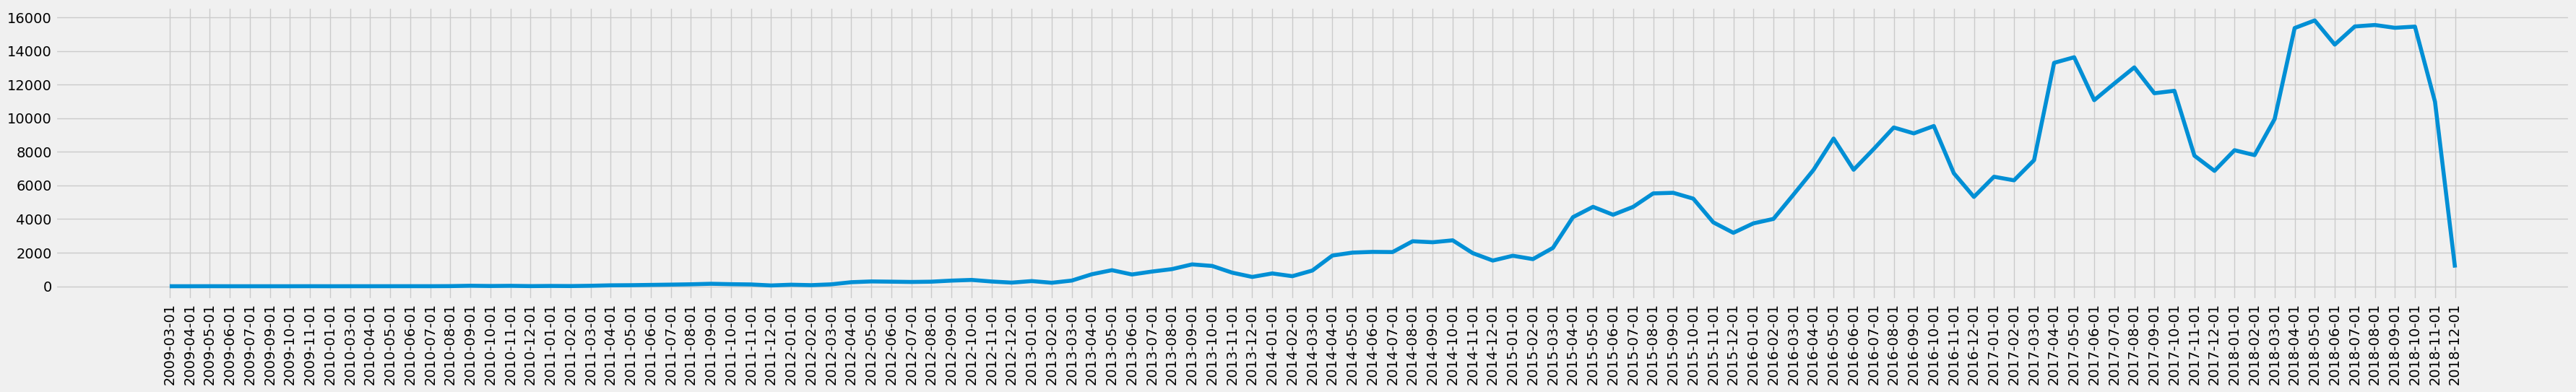

In [18]:
plt.figure(figsize=(40,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!
plt.xticks(rotation=90)
plt.plot(monthly_count)
plt.savefig('prelim_timeseries.png', bbox_inches='tight', dpi=100)

#### Whilst the range of dates (12 months, over 9 years, so over 100+ time values) is large, we can see both trend and seasonality occuring in this time series plot.

#### The Trend is uphill - Over time, there are an increasing count of new reviews posted to airbnb. It's hard to decifer the exact seasonality of the review count in this Notebooks version of the plot, but if you review the saved .png output, then it becomes apparant the dips in review counts tend to consistently occur around Nov-Feb each year.

#### There is really no visible change in the values on the line up until around 2014, so moving forward the data set will be reduced to 2014 and beyond values. Additionally, I'll be removing the Dec 2018 values 9Final plot) the reason for this is because the decrease is attributed to the collection method & timings (originally scraped mid-Dec 2018, so they do not represent a full month's values)

In [19]:
# Create a subset based on values after a certain date range
start_date = '2014-01-01'
end_date = '2018-11-01'
correct_range = monthly_count[monthly_count.index > start_date]
correct_range = correct_range[correct_range.index <= end_date]
correct_range.shape

(58, 1)

In [20]:
correct_range.head()

,listing_count
month_year,
2014-02-01,598
2014-03-01,936
2014-04-01,1827
2014-05-01,2001
2014-06-01,2044


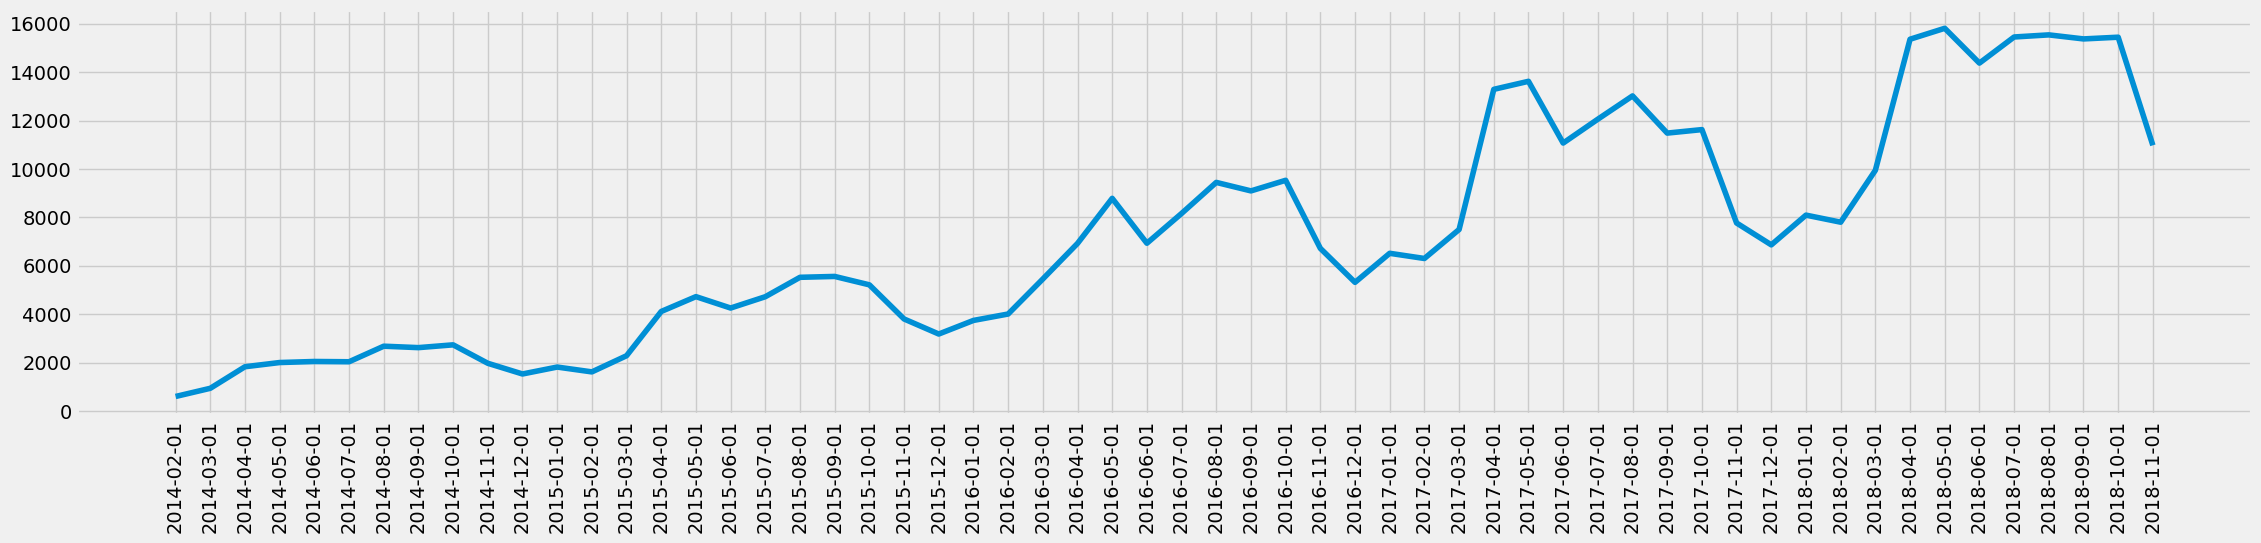

In [21]:
plt.figure(figsize=(25,5), dpi=100)
plt.xticks(rotation=90)
plt.plot(correct_range)
plt.savefig('updated_range_timeseries.png', bbox_inches='tight', dpi=100)

#### Now that we have a smaller range which is more indicative of the actual entities tragectaroy (rather than the initial extremely slow first 5 years) we should have a better set of data to perform our decomposition on.

In [22]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(correct_range, model='additive', period=12)

In [23]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

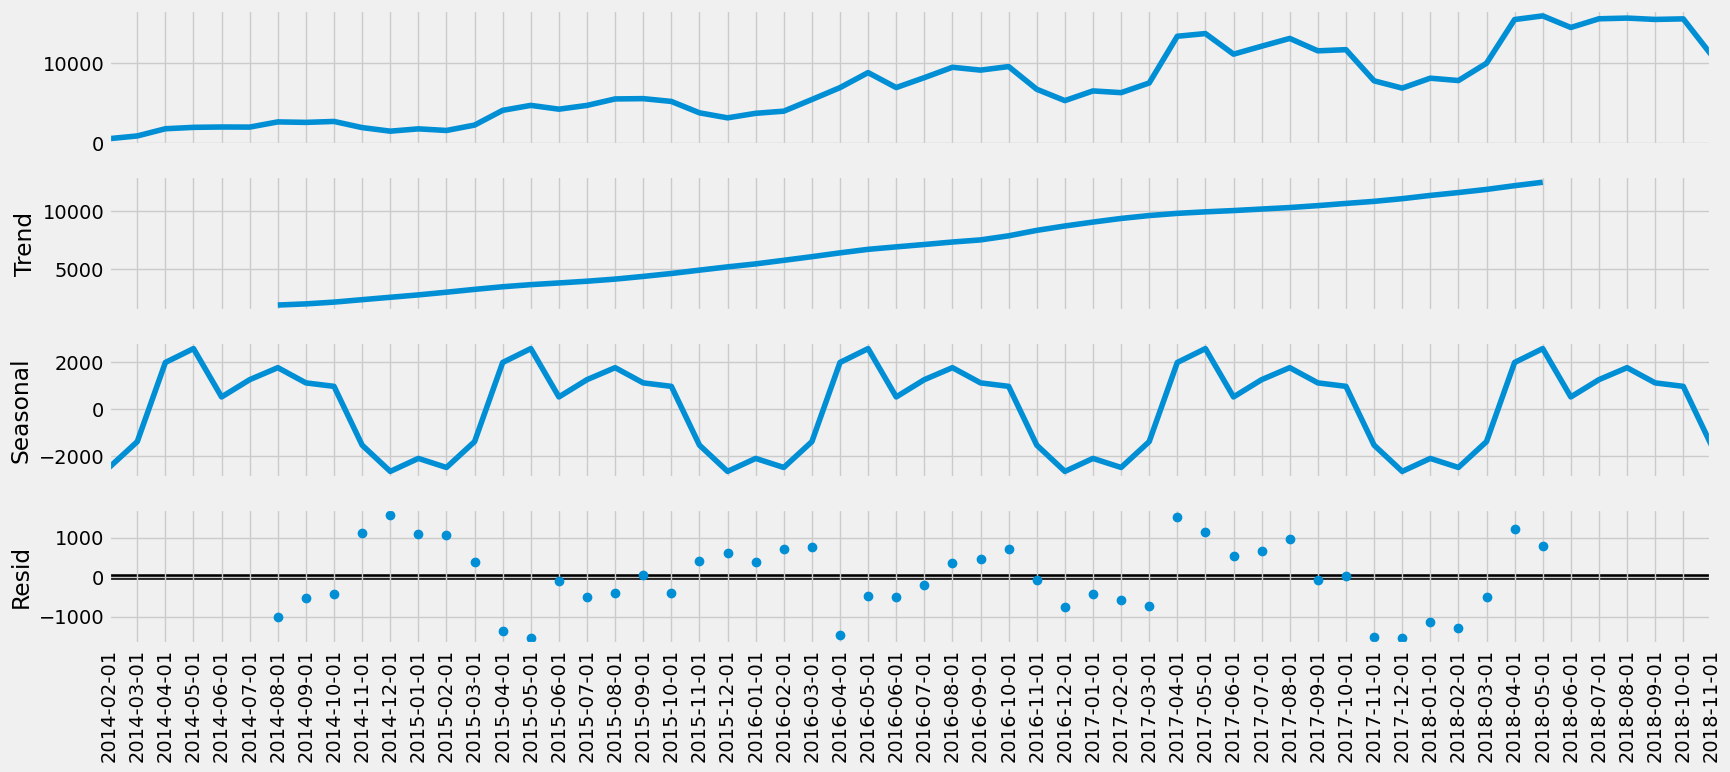

<Figure size 1800x700 with 0 Axes>

In [24]:
# Plot the separate components
decomposition.plot()
plt.xticks(rotation=90)
plt.show()
plt.savefig('decomposition_charts', bbox_inches='tight', dpi=100)

#### The LEVEL (first chart) looks as expected, it follows the line of the main data plot. This means that it has an upwards trend with some smaller first quarter dips each year.
#### The Trend also matches our expectation. There is visible smoothening compared to the level with most of the noise associated to those aformention first quarter decreases having been removed. There is a dominant trend.
#### Evidently there is a lot of seasonality in this time series. There are consistent peaks and valleys with a strong variation between the highs/lows respectively.
#### Finally, there is a lot of unexplained noise in the data represented by the 'residual' chart, showing high variability thoughout the years, particularly during the outlined 'seasons' that we anticipated we'd see.

### Section 4: Testing for Stationarity (v1.)

In [25]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(correct_range['listing_count'])

Dickey-Fuller Stationarity test:
Test Statistic                  0.599526
p-value                         0.987604
Number of Lags Used            11.000000
Number of Observations Used    46.000000
Critical Value (1%)            -3.581258
Critical Value (5%)            -2.926785
Critical Value (10%)           -2.601541
dtype: float64


#### Since the test statistic value is higher than the Critical Value results, we cannot at this moment disprove the precense of a unit root. This means that our data is, for the time-being, non-stationary.

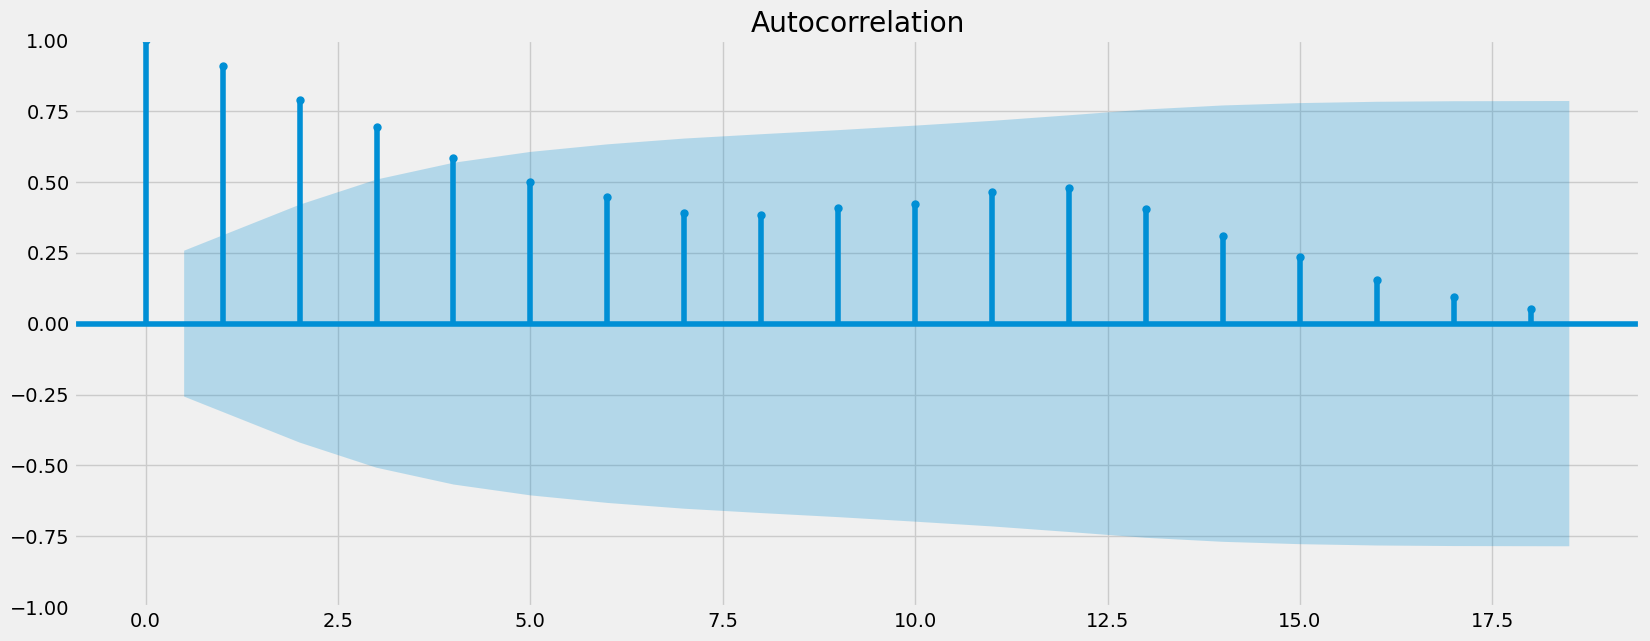

<Figure size 1800x700 with 0 Axes>

In [26]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(correct_range)
plt.show()
plt.savefig('Auto_correlation_charts', bbox_inches='tight', dpi=100)

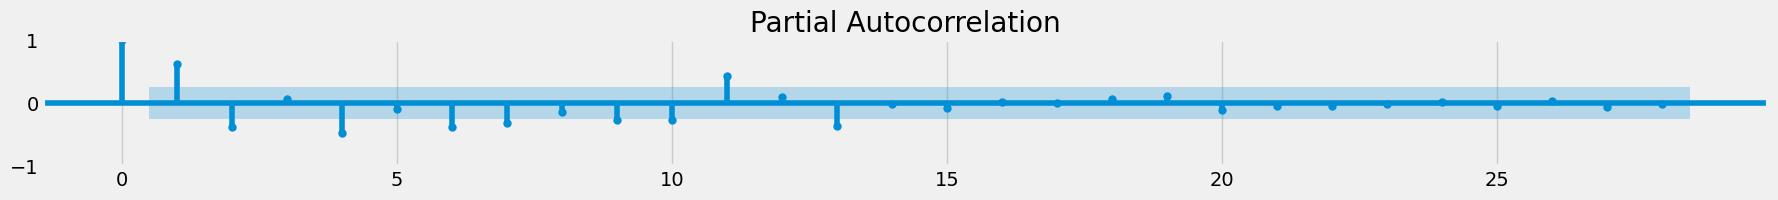

In [27]:
plt.subplot(413)
plot_pacf(decomposition.seasonal.dropna(), lags=28, ax=plt.gca())
plt.tight_layout()
plt.show()

#### Based of the Auto-correlation chart above, there aren't that many lags outside of the blue area meaning there isn't an overly large amount of autocorrelated data in our set. We know from the obvious trend and seasonality lines from before, and our Dickey_Fuller test that the data is non-stationary so we will need to conduct additional differencing techniques before retesting our data for sationarity.

### Section 5: Stationarizing

In [28]:
data_diff = correct_range - correct_range.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [29]:
data_diff.dropna(inplace = True) # I've removed the missing values that came about as a result of the differencing.

In [30]:
data_diff.head()

,listing_count
month_year,
2014-03-01,338.0
2014-04-01,891.0
2014-05-01,174.0
2014-06-01,43.0
2014-07-01,-11.0


In [31]:
data_diff.columns

Index(['listing_count'], dtype='object')

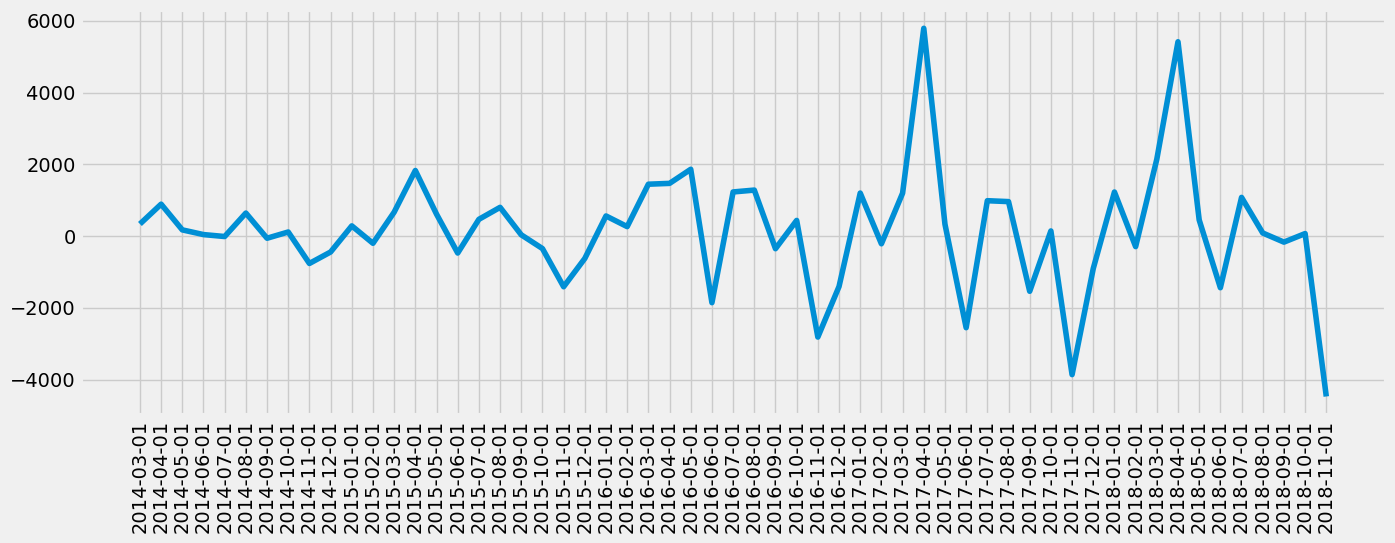

<Figure size 1800x700 with 0 Axes>

In [32]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)
plt.xticks(rotation=90)
plt.show()
plt.savefig('differenced_data', bbox_inches='tight', dpi=100)

#### Following using 1 round of differencing, the data is much more constant, though as we progress further down the time-series, we do so an increase in variance. To my eyes, this isn't fully stationary as a result, but we need to conduct further testing to prove whether it is or isn't.

In [33]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.250777
p-value                         0.017227
Number of Lags Used            11.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


#### Based on the results of our post-differencing dickey_fuller test we are able to reject the null-hypothesis regarding the presence of the unit root. The Test Statistic is smaller than the critical Value (5%), as well as having a necessarily small p-value of 0.017. This means that we could conceivable consider our time-series data as stationary.

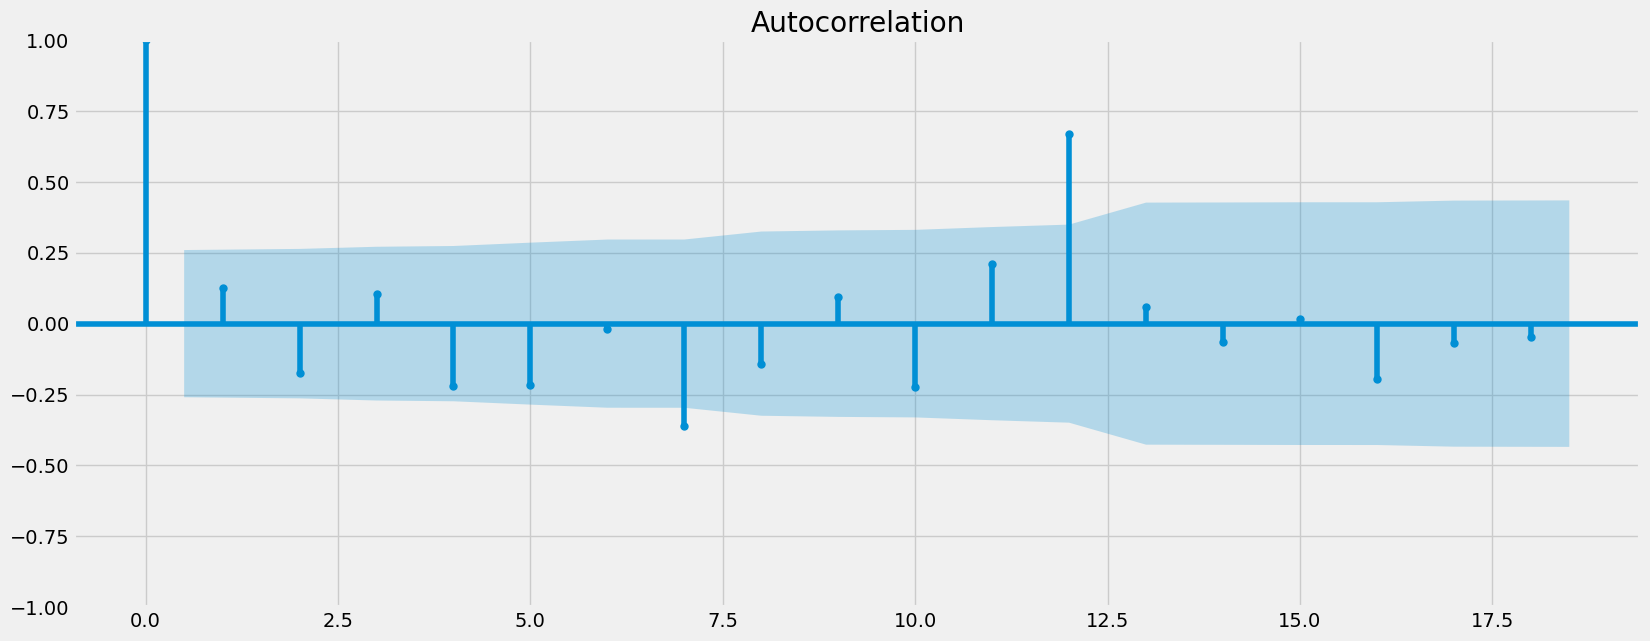

<Figure size 1800x700 with 0 Axes>

In [34]:
plot_acf(data_diff)
plt.show()
plt.savefig('Auto_correlation_charts_2', bbox_inches='tight', dpi=100)

#### There is a strong lack of Auto-correlation in our differenced data set. After 1 Lag, there is swift decrease in ACF, bringing the majority of the subsequent lag values to within the blue area which represents confidence level. This implies that most lags are not significantly correlated with each other. There is 1 minor deviation to above this threshold at the 7th lag, and then a more significant one at 12.

##### Second round of differencing currently marked as 'mark down' cells instead so that they don't run and cause slow down

data_diff2 = data_diff - data_diff.shift(1)
data_diff2.dropna(inplace = True)
data_diff2.head()

# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)
plt.xticks(rotation=90)
plt.show()
plt.savefig('differenced_data2', bbox_inches='tight', dpi=100)

dickey_fuller(data_diff2)

plot_acf(data_diff2)
plt.show()

decomposition_data_diff2 = sm.tsa.seasonal_decompose(data_diff2, model='additive', period=12)

# Plot the separate components
decomposition_data_diff2.plot()
plt.xticks(rotation=90)
plt.show()

trend_diff2 = decomposition_data_diff2.trend
seasonal_diff2= decomposition_data_diff2.seasonal
residual_diff2 = decomposition_data_diff2.resid

plot_acf(seasonal_diff2)
plt.show()

train2 = data_diff2['listing_count'][:46]
test2 = data_diff2['listing_count'][45:]

test2.shape

model = sm.tsa.statespace.SARIMAX(train2, order=(1, 2, 1), seasonal_order=(1, 0, 0, 12)) 
fitted = model.fit()  
print(fitted.summary()) # Check model summary

forecast_values = fitted.forecast(11, alpha=0.05)
fc = forecast_values # Forecasted values
fc_series = pd.Series(fc, index=test2.index) # This creates the forecasted curve

forecast_object = fitted.get_forecast(steps=11, alpha=0.05)
conf_int = forecast_object.conf_int()

#Create pandas series for lower and upper bounds of the confidence interval
lower_series = pd.Series(conf_int.iloc[:, 0], index=test2.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test2.index) # The above code uses
#iloc to access the columns of the conf_int DataFrame correctly, ensuring that the lower_series and upper_series are created with the appropriate data.#Plot the forecast and confidence interval

plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train2, label='training')
plt.plot(test2, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(test2.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=90)

plt.show()

#### Performing a log transform on original data instead of differencing

In [35]:
log_transformed_data = np.log(correct_range)
log_transformed_data.head()

,listing_count
month_year,
2014-02-01,6.393591
2014-03-01,6.841615
2014-04-01,7.510431
2014-05-01,7.601402
2014-06-01,7.622664


In [36]:
log_transformed_data.columns

Index(['listing_count'], dtype='object')

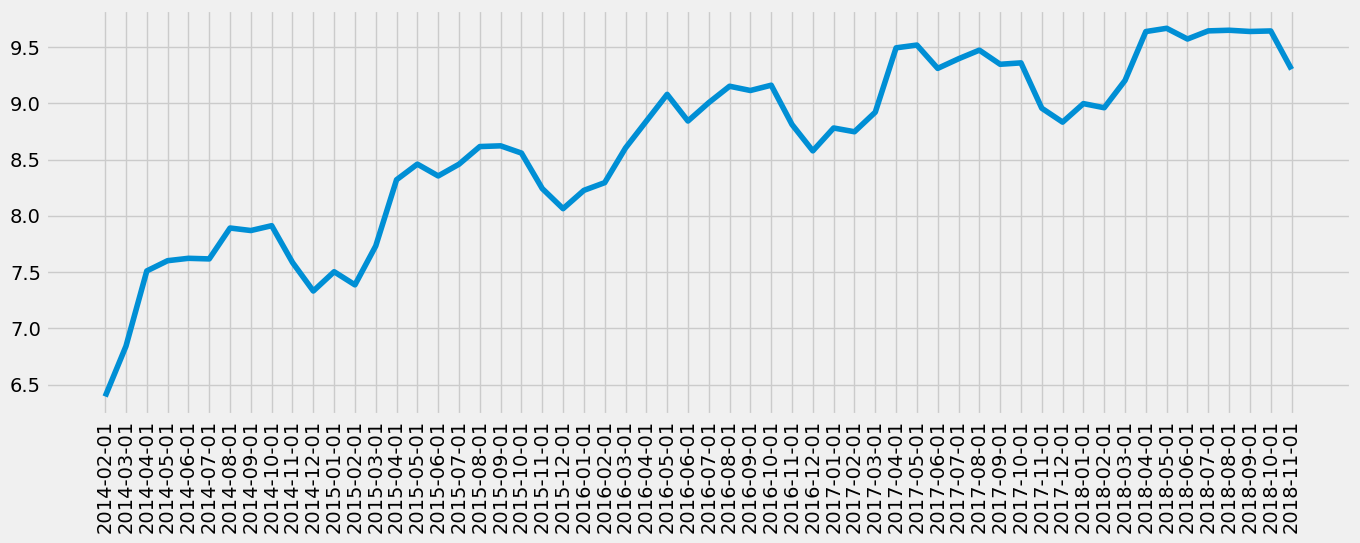

<Figure size 1800x700 with 0 Axes>

In [37]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(log_transformed_data)
plt.xticks(rotation=90)
plt.show()
plt.savefig('log_tranform_data', bbox_inches='tight', dpi=100)

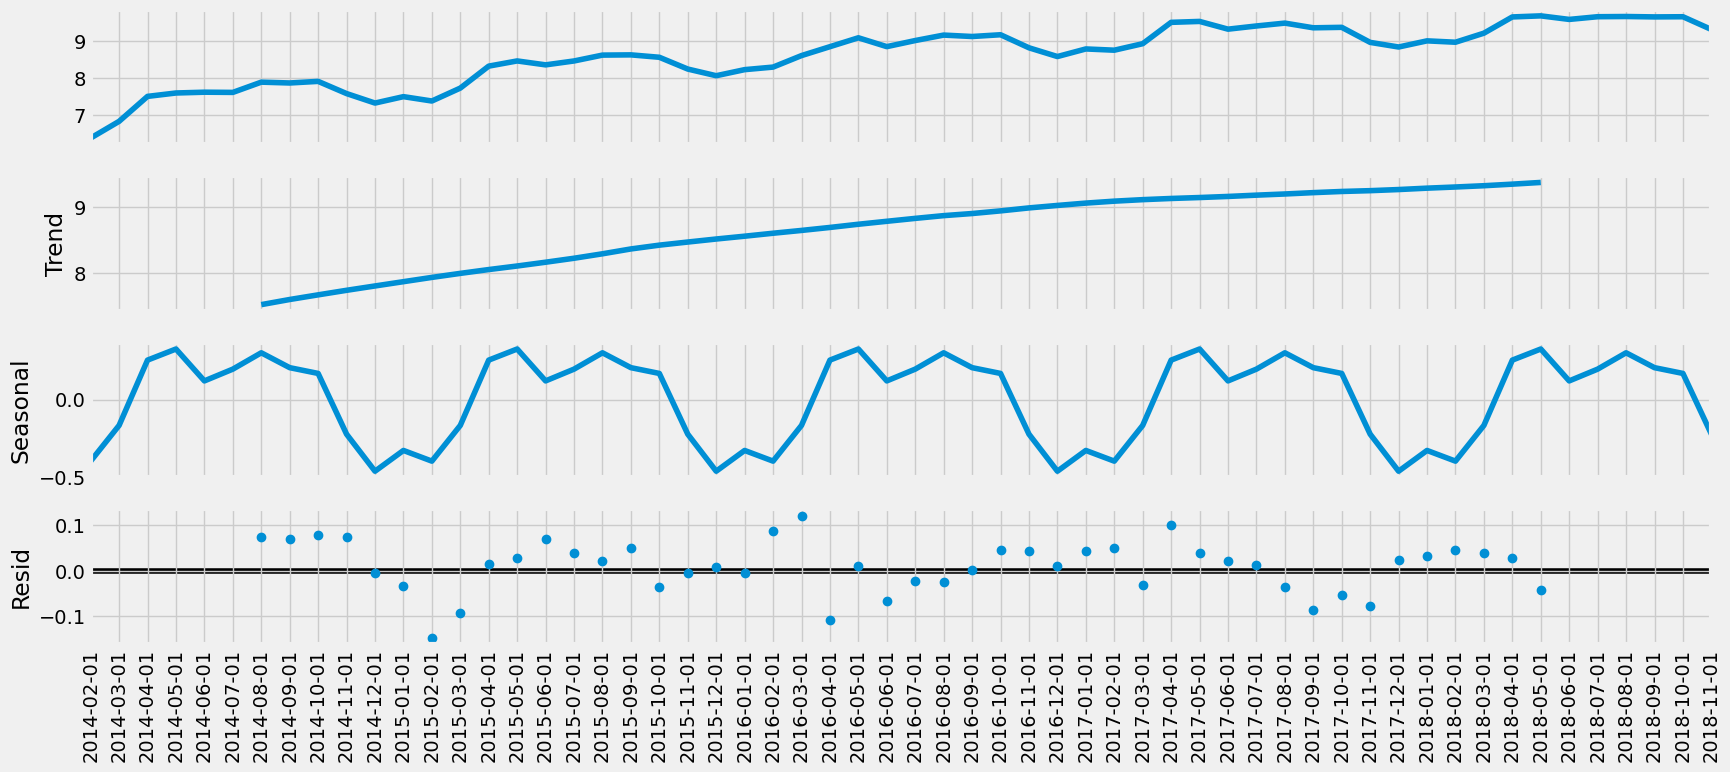

<Figure size 1800x700 with 0 Axes>

In [38]:
decomposition2 = sm.tsa.seasonal_decompose(log_transformed_data, model='additive', period=12)
decomposition2.plot()
plt.xticks(rotation=90)
plt.show()
plt.savefig('decomposition2_charts', bbox_inches='tight', dpi=100)

In [39]:
dickey_fuller(log_transformed_data)

Dickey-Fuller Stationarity test:
Test Statistic                -7.583252e+00
p-value                        2.647479e-11
Number of Lags Used            1.100000e+01
Number of Observations Used    4.600000e+01
Critical Value (1%)           -3.581258e+00
Critical Value (5%)           -2.926785e+00
Critical Value (10%)          -2.601541e+00
dtype: float64


#### Stationarity implied by the Test Stat being lower that all crit values %s

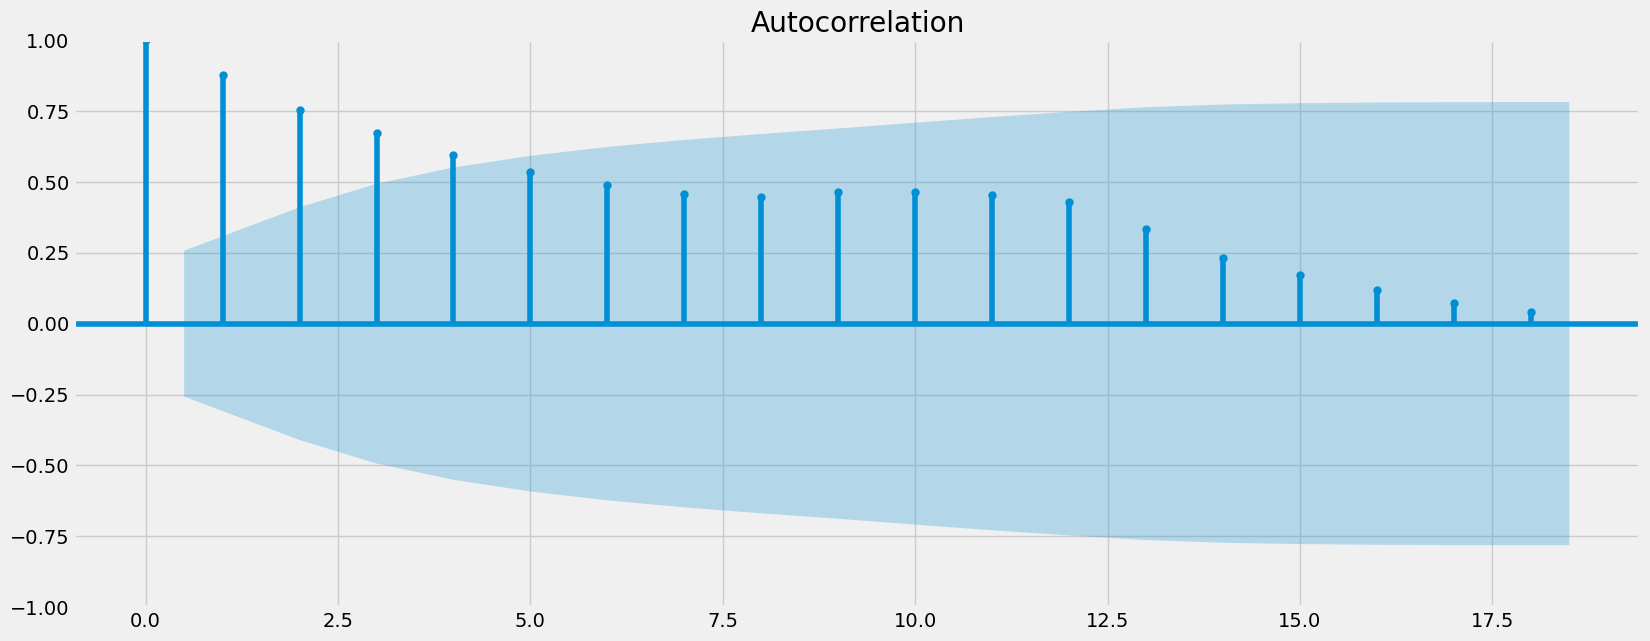

<Figure size 1800x700 with 0 Axes>

In [40]:
plot_acf(log_transformed_data)
plt.show()
plt.savefig('auto_correl_after_log_charts_2', bbox_inches='tight', dpi=100)

In [41]:
log_transformed_data.to_csv(os.path.join(path,'log_transformed_data.csv'))
log_transformed_data.shape

(58, 1)

In [42]:
log_transformed_data.columns

Index(['listing_count'], dtype='object')

### 2nd round of Log transform

In [43]:
log_transformed_data_2 = np.log10(log_transformed_data)
log_transformed_data_2.head()

,listing_count
month_year,
2014-02-01,0.805745
2014-03-01,0.835159
2014-04-01,0.875665
2014-05-01,0.880894
2014-06-01,0.882107


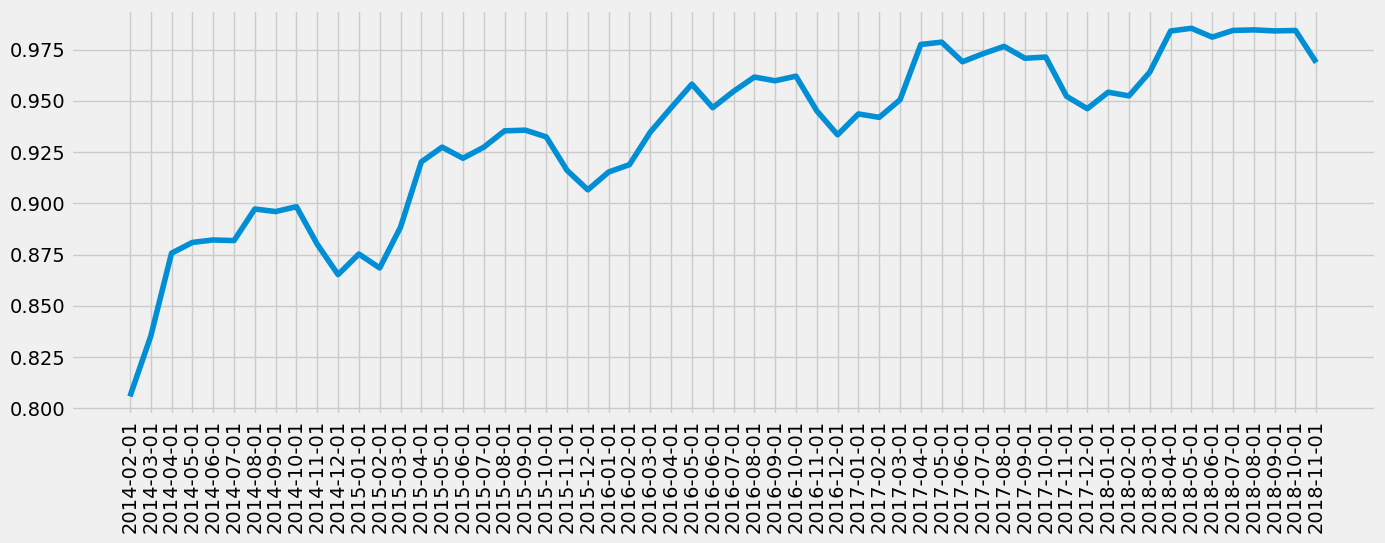

<Figure size 1800x700 with 0 Axes>

In [44]:
# Check out what the log transform did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(log_transformed_data_2)
plt.xticks(rotation=90)
plt.show()
plt.savefig('log_transformed_data_2', bbox_inches='tight', dpi=100)

#### The Seasonality is still present, the 2nd round of tranformation only seems to have reduced the range of y values, instead of making any significant changes.

#### Dickey Fuller test has a slightly stronger test result, but we had already passed the test with flying colours previously anyway.

In [45]:
dickey_fuller(log_transformed_data_2)

Dickey-Fuller Stationarity test:
Test Statistic                -8.342770e+00
p-value                        3.143509e-13
Number of Lags Used            1.100000e+01
Number of Observations Used    4.600000e+01
Critical Value (1%)           -3.581258e+00
Critical Value (5%)           -2.926785e+00
Critical Value (10%)          -2.601541e+00
dtype: float64


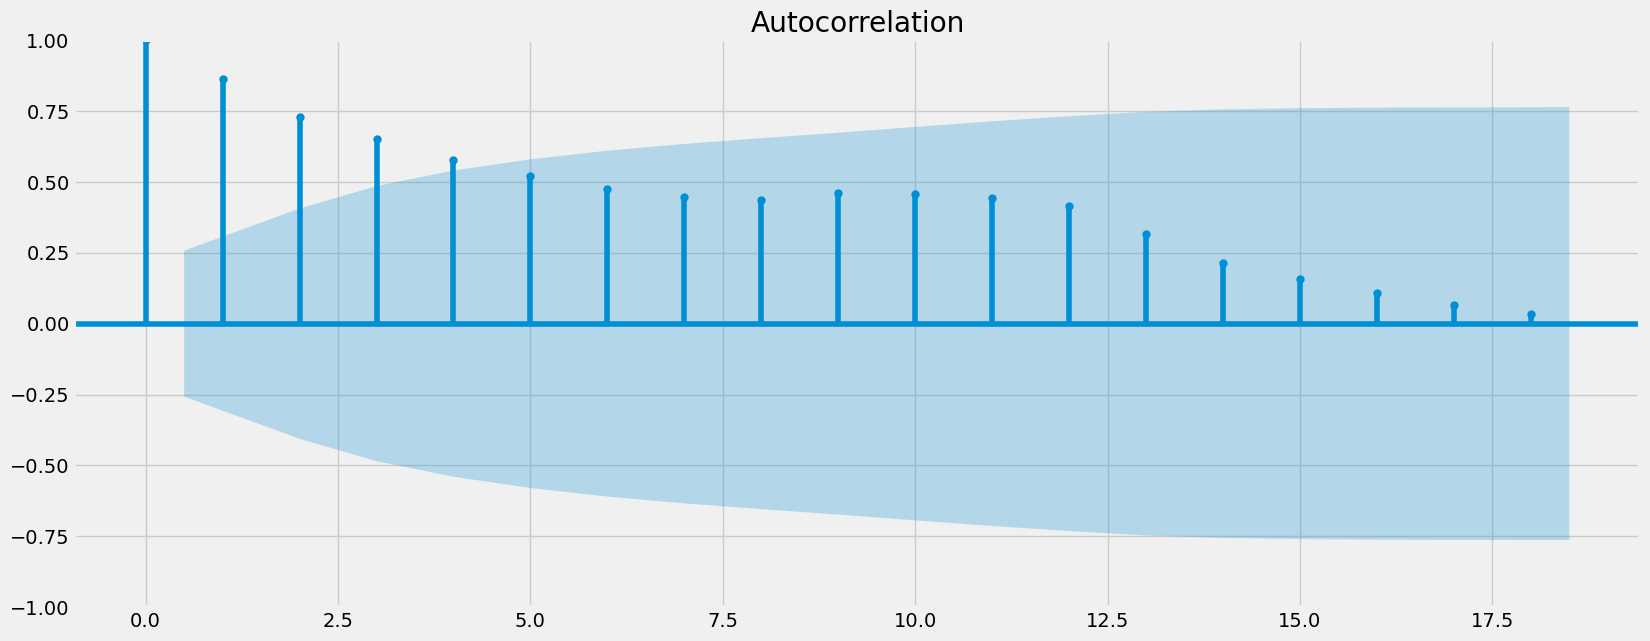

<Figure size 1800x700 with 0 Axes>

In [46]:
plot_acf(log_transformed_data_2)
plt.show()
plt.savefig('auto_correl_after_log_charts_2', bbox_inches='tight', dpi=100)

#### No difference on the Autocorrelation test either. ACF value drops to beneath the significance level after the 4th lag.

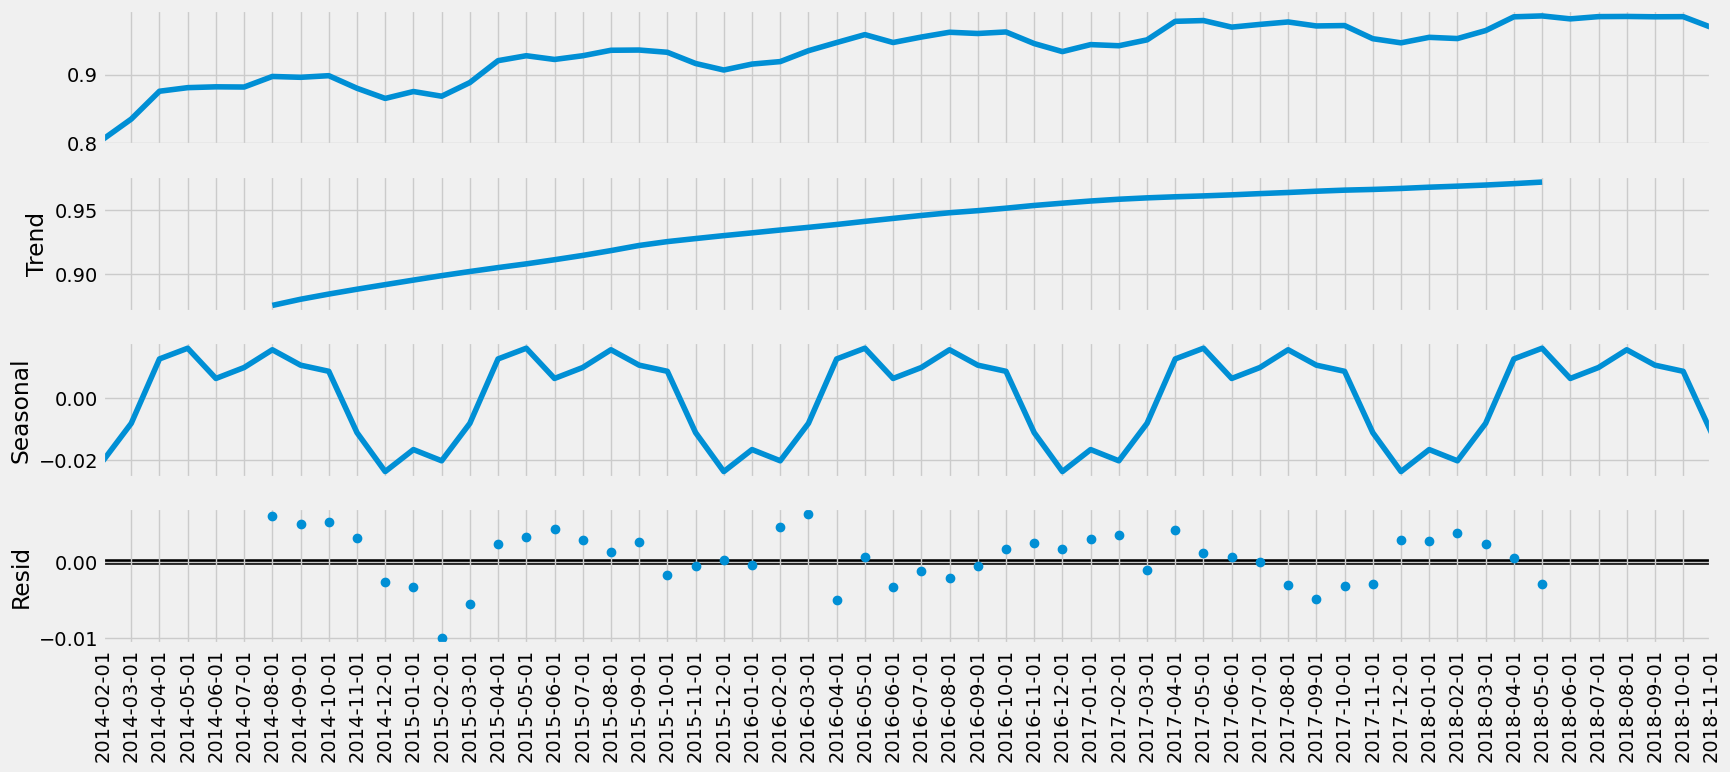

<Figure size 1800x700 with 0 Axes>

In [47]:
decomposition3 = sm.tsa.seasonal_decompose(log_transformed_data_2, model='additive', period=12)
decomposition3.plot()
plt.xticks(rotation=90)
plt.show()
plt.savefig('decomposition3_charts', bbox_inches='tight', dpi=100)

In [48]:
trend3 = decomposition3.trend
seasonal3 = decomposition3.seasonal
residual3 = decomposition3.resid

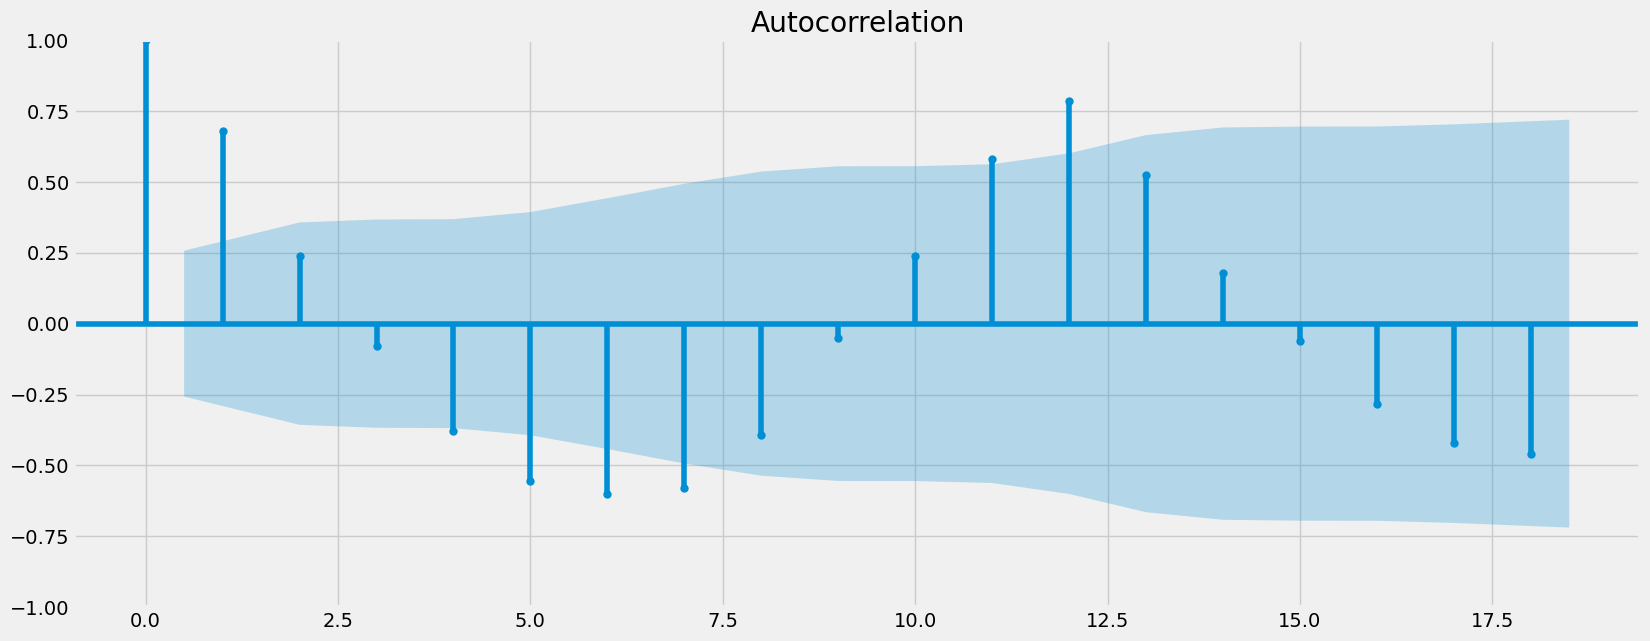

<Figure size 1800x700 with 0 Axes>

In [49]:
plot_acf(seasonal3)
plt.show()
plt.savefig('Auto_correlation_charts', bbox_inches='tight', dpi=100)

### Using differencing instead of a second round of Log transform

In [50]:
differenced_log = log_transformed_data - log_transformed_data.shift(1)

In [51]:
differenced_log.dropna(inplace = True)

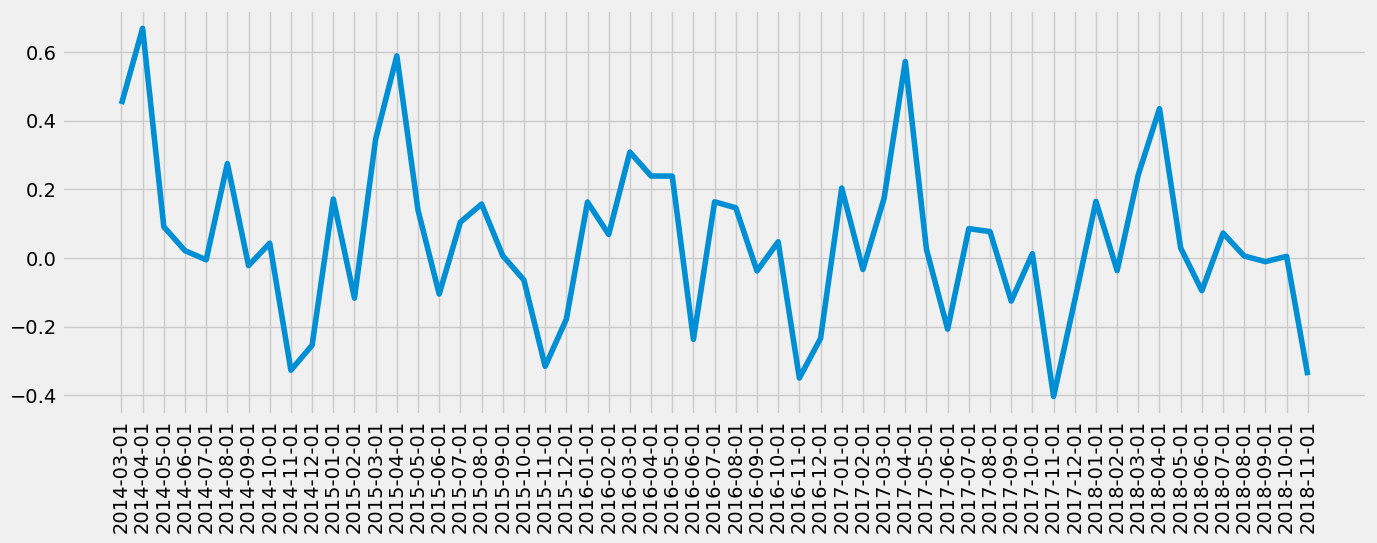

<Figure size 1800x700 with 0 Axes>

In [52]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(differenced_log)
plt.xticks(rotation=90)
plt.show()
plt.savefig('differenced_data2', bbox_inches='tight', dpi=100)

In [53]:
dickey_fuller(differenced_log)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.571047
p-value                         0.498119
Number of Lags Used            11.000000
Number of Observations Used    45.000000
Critical Value (1%)            -3.584829
Critical Value (5%)            -2.928299
Critical Value (10%)           -2.602344
dtype: float64


#### dickey-Fuller test not passed as the test stat is not lower than the crit values

In [54]:
differenced_log2 = differenced_log - differenced_log.shift(1)

In [55]:
differenced_log2.dropna(inplace = True)

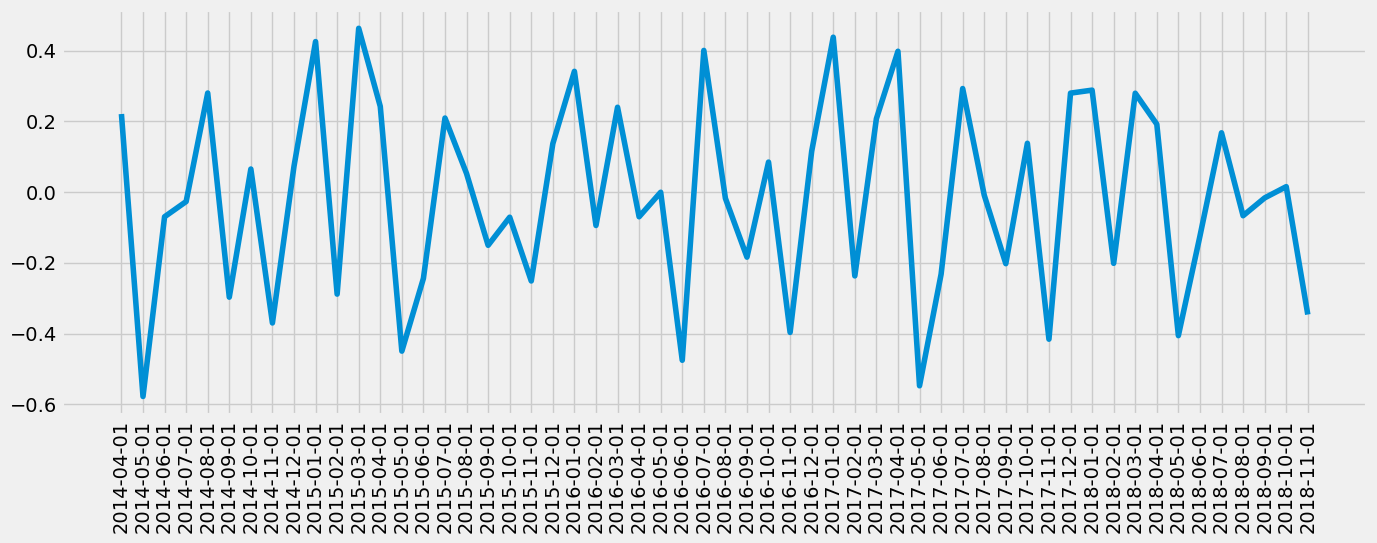

<Figure size 1800x700 with 0 Axes>

In [56]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(differenced_log2)
plt.xticks(rotation=90)
plt.show()
plt.savefig('differenced_data3', bbox_inches='tight', dpi=100)

In [57]:
dickey_fuller(differenced_log2)

Dickey-Fuller Stationarity test:
Test Statistic                -8.583443e+00
p-value                        7.618607e-14
Number of Lags Used            1.100000e+01
Number of Observations Used    4.400000e+01
Critical Value (1%)           -3.588573e+00
Critical Value (5%)           -2.929886e+00
Critical Value (10%)          -2.603185e+00
dtype: float64


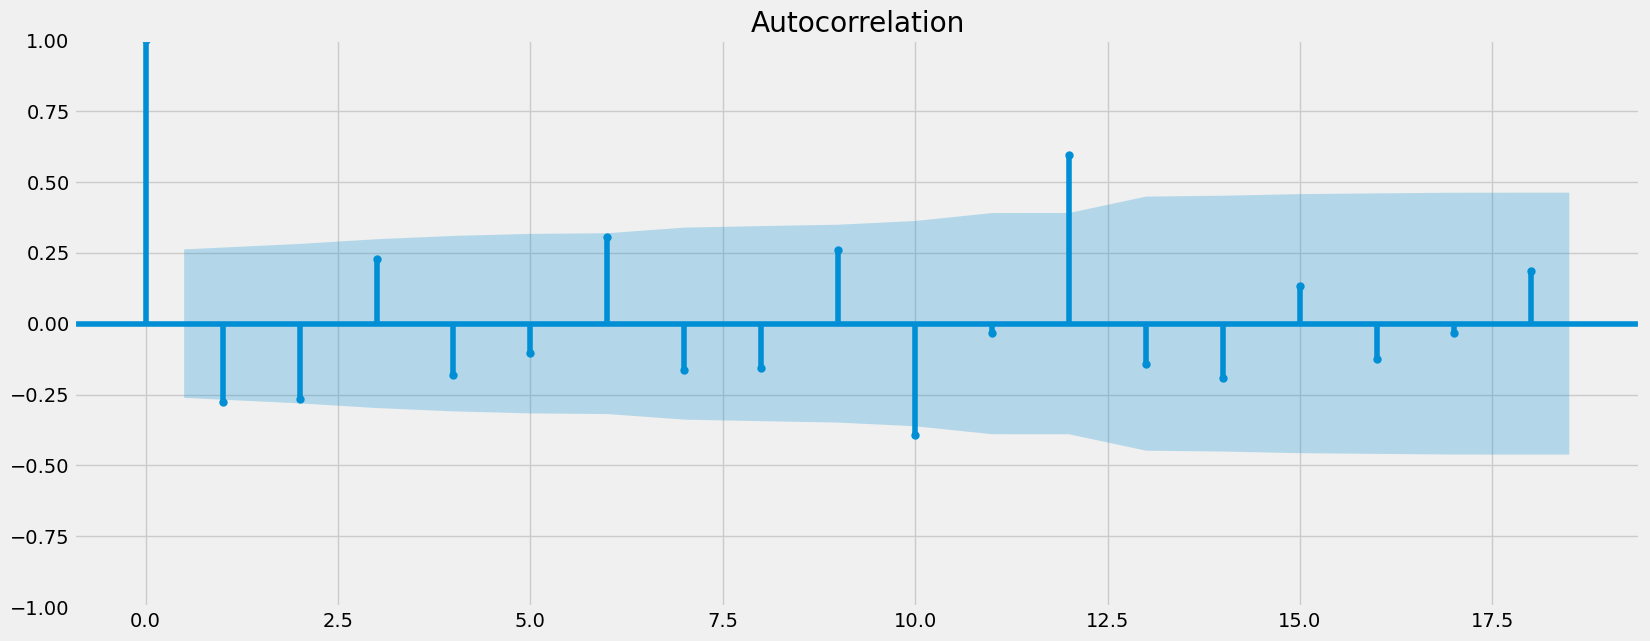

<Figure size 1800x700 with 0 Axes>

In [58]:
plot_acf(differenced_log2)
plt.show()
plt.savefig('auto_correl_differenced_log2', bbox_inches='tight', dpi=100)

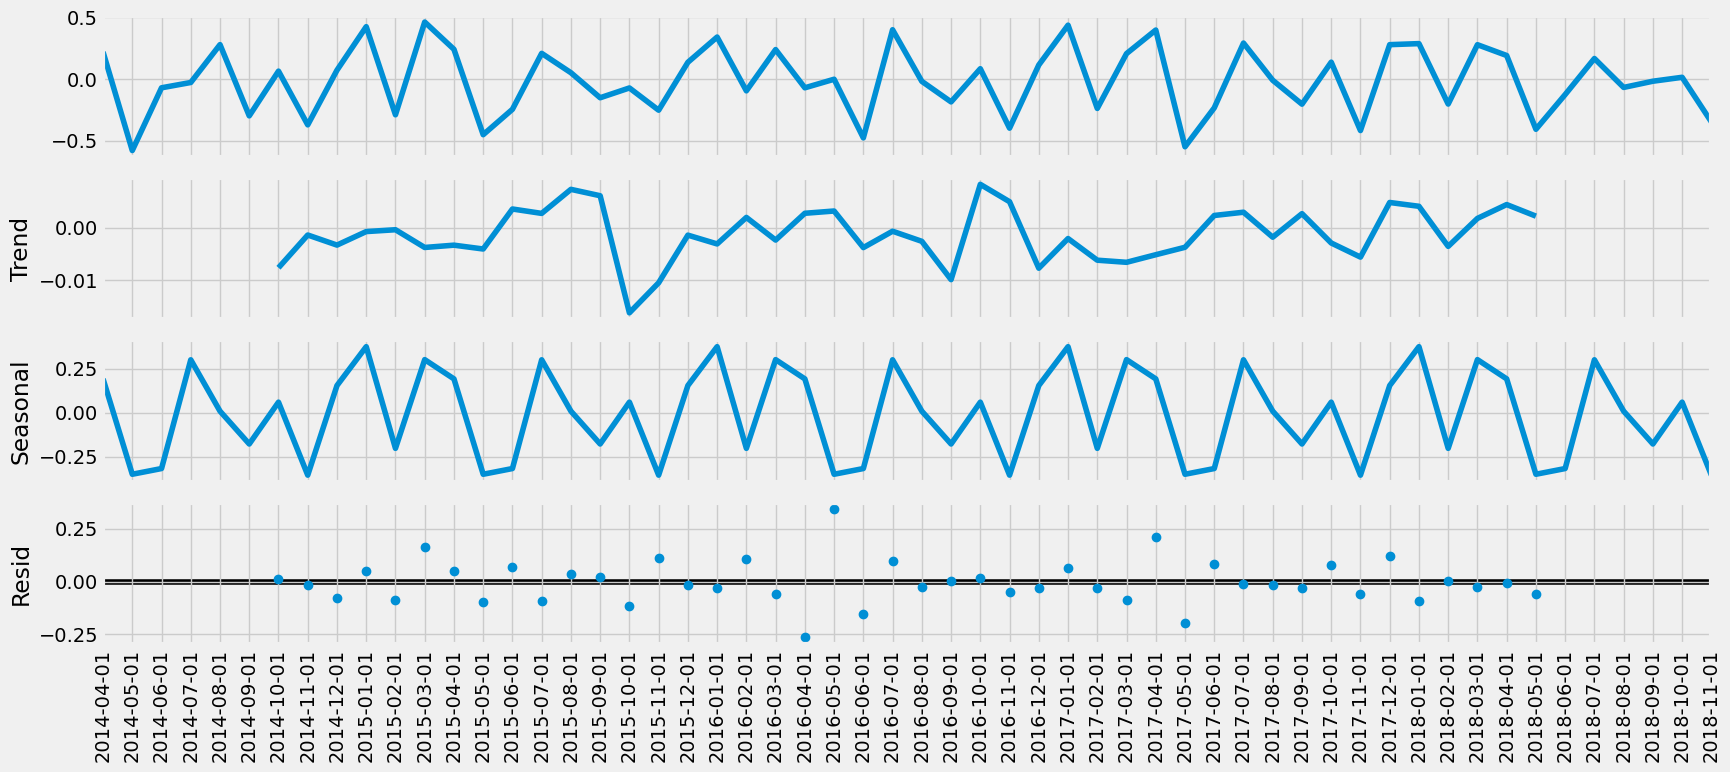

<Figure size 1800x700 with 0 Axes>

In [59]:
decomposition4 = sm.tsa.seasonal_decompose(differenced_log2, model='additive', period=12)
decomposition4.plot()
plt.xticks(rotation=90)
plt.show()
plt.savefig('decomposition4_charts', bbox_inches='tight', dpi=100)

In [60]:
trend4 = decomposition4.trend
seasonal4 = decomposition4.seasonal
residual4 = decomposition4.resid

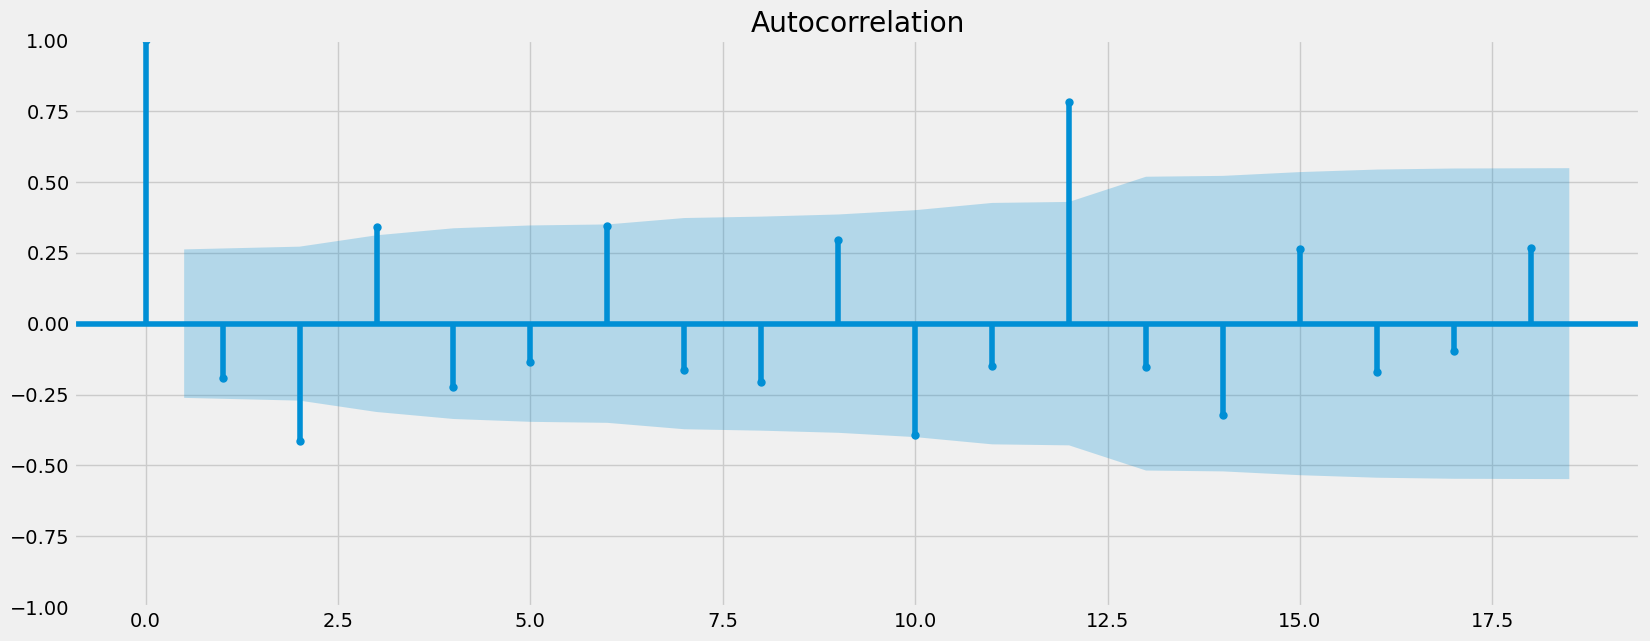

In [61]:
plot_acf(seasonal4)
plt.show()

##  6.6 Bonus Task - ARIMA Forecasting

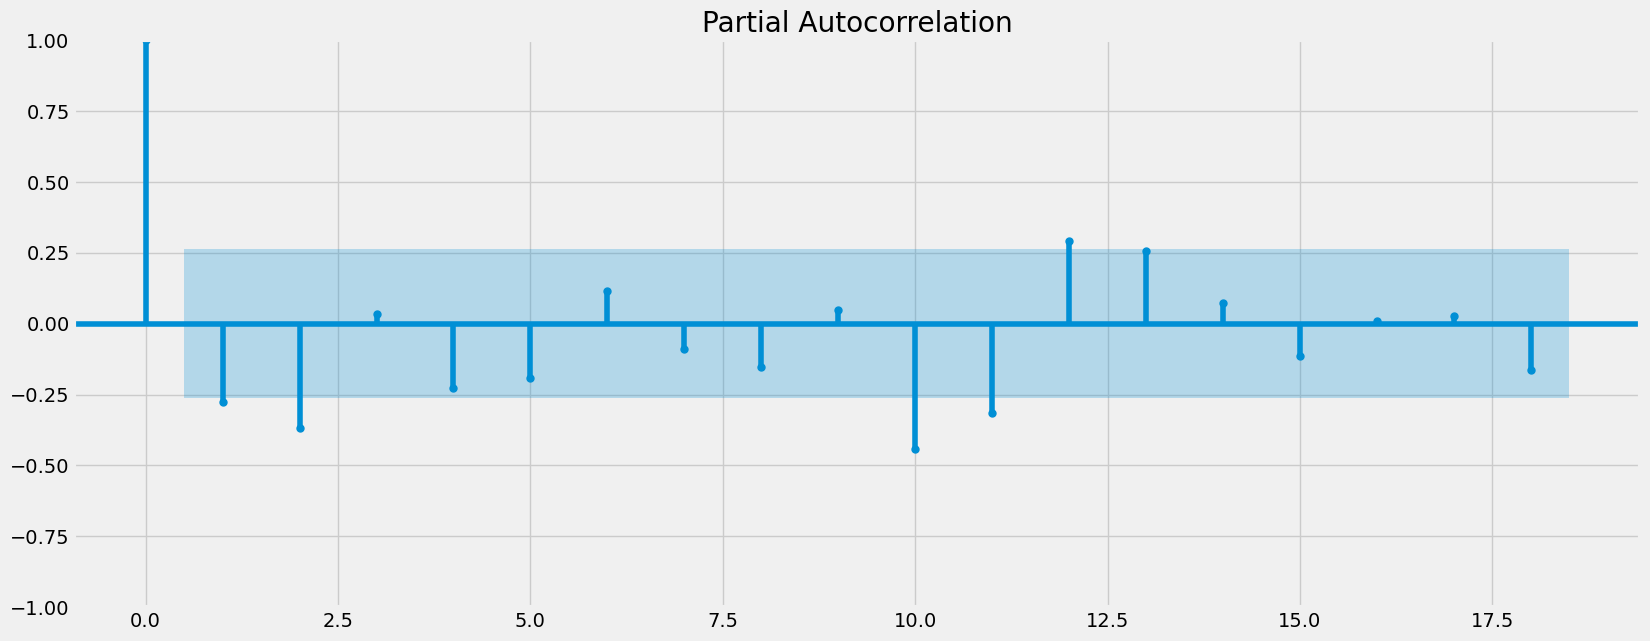

<Figure size 4500x4500 with 0 Axes>

In [62]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(differenced_log2)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

#### Determining Parameter P > We will start with 1, as the values appear to not be significantly correlated following the second lag.

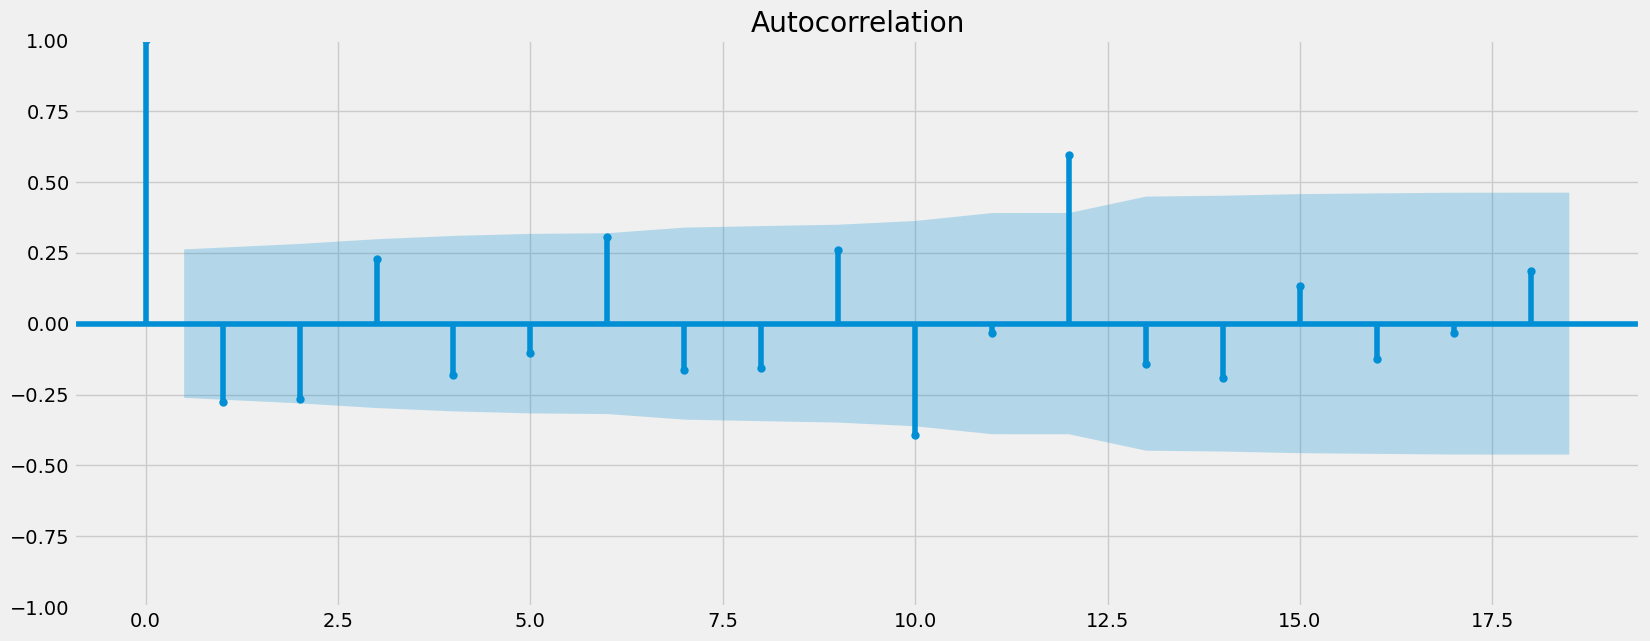

<Figure size 1500x500 with 0 Axes>

In [63]:
# Plot autocorrelations to determine parameter q

plot_acf(differenced_log2)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

#### Parameter Q defined by the quantity of lags outside of the blue zone, Q = 3

In [64]:
#In order to create the train / test split, we'll try and recreate a years worth of value (2018 stats)

train = differenced_log2['listing_count'][:46]
test = differenced_log2['listing_count'][45:]

In [65]:
test.shape

(11,)

In [66]:
from statsmodels.tsa.api import ARIMA # Import the model you need

C:\Users\mojos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mojos\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\mojos\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                       listing_count   No. Observations:                   46
Model:             SARIMAX(1, 3, 1)x(1, 0, [], 12)   Log Likelihood                 -31.065
Date:                             Sat, 20 Apr 2024   AIC                             70.131
Time:                                     09:26:39   BIC                             77.176
Sample:                                 04-01-2014   HQIC                            72.729
                                      - 01-01-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7460      0.131     -5.712      0.000      -1.002      -0.490
ma.L1         -0.9992      

C:\Users\mojos\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
C:\Users\mojos\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


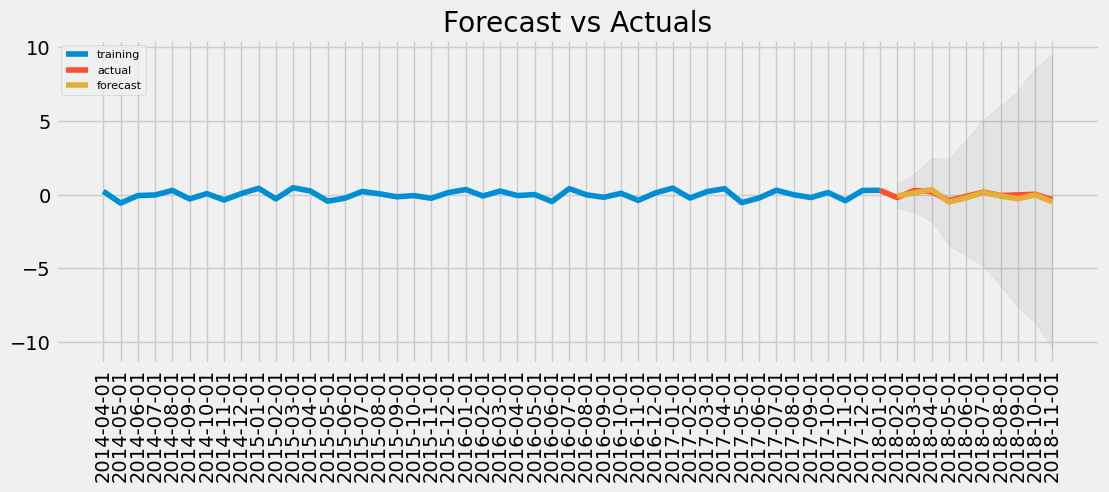

In [68]:
model = sm.tsa.statespace.SARIMAX(train, order=(1, 3, 1), seasonal_order=(1, 0, 0, 12)) 
fitted = model.fit()  
print(fitted.summary()) # Check model summary

forecast_values = fitted.forecast(11, alpha=0.05)
fc = forecast_values # Forecasted values
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve

forecast_object = fitted.get_forecast(steps=11, alpha=0.05)
conf_int = forecast_object.conf_int()

#Create pandas series for lower and upper bounds of the confidence interval
lower_series = pd.Series(conf_int.iloc[:, 0], index=test.index)
upper_series = pd.Series(conf_int.iloc[:, 1], index=test.index) # The above code uses
#iloc to access the columns of the conf_int DataFrame correctly, ensuring that the lower_series and upper_series are created with the appropriate data.#Plot the forecast and confidence interval

plt.figure(figsize=(12, 4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(test.index, lower_series, upper_series, color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.xticks(rotation=90)
plt.show()